In [1]:
#import numpy as np
from PIL import Image # libary used to open and manipulate images
import torch #PyTorch libary, as I could not make it work with TensorFlow at all
import torch.nn as nn #import neural network module from PyTorch
import torch.nn.functional as F # to import functions like ReLu

In [2]:
import torch.optim as optim   #to import optimizer like SGD
import torchvision #to be used as pre-train data
import torchvision.transforms as transforms # to do image transformation like resize
from torch.utils.data import DataLoader, Dataset # to handle the data and shuffling
from torchvision.datasets import ImageFolder #to load and organized the data

In [3]:
import fsspec # to support remote access Hadoop, as I could not make PyArrow connnect tto hhddfs at all
from io import BytesIO #to read images from memory

# Define transformations
# transform = transforms.Compose([
#      transforms.Grayscale(num_output_channels=1),  # Ensures grayscale (1 channel)
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

In [4]:
#this is a test that I did, so Spark can connect to hdsf but not to manage images
df = spark.read.format("binaryFile").load("hdfs://localhost:9000/faces/train/sad/*.jpg")
df.show(15)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|hdfs://localhost:...|2025-03-20 12:48:...|  2253|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:38:...|  2233|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 13:01:...|  2231|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:50:...|  2208|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:27:...|  2164|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:12:...|  2146|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:36:...|  2143|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:24:...|  2037|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:50:...|  2036|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:41:...|  2034|[FF D8 FF E0 00 1...|
|hdfs://localhost:...|2025-03-20 12:51:...|  2034|[FF D8 FF E0 0

In [18]:
#Another test but it just get the urlss connect to hdsf but not to manage images

df = spark.read.format("image").load("hdfs://localhost:9000/faces/train/sad")
df.show(5)


+--------------------+
|               image|
+--------------------+
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
+--------------------+
only showing top 5 rows



In [4]:
# the class come from PyTorch
class HDFSDataset(Dataset):
    def __init__(self, hdfs_path, transform=None): #this is the constructor method, transform none by default, but i will aplly when loading it
        self.fs = fsspec.filesystem('hdfs', host='localhost', port=9000)
        # Use fsspec to get a list of image file paths
        self.image_paths = self.fs.glob(hdfs_path + "/*.jpg") + self.fs.glob(hdfs_path + "/*.png")
        # Assign labels based on folder name (0 for happy, 1 for sad)
        self.labels = [0 if "happy" in path else 1 for path in self.image_paths]  
        self.transform = transform
    
    def __len__(self):
        # Return the number of files
        return len(self.image_paths)
    
    def __getitem__(self, idx):

        # Get the image path at the index
        img_path = self.image_paths[idx]
        
        # Read the image file in binary mode and convert it to an image
        with self.fs.open(img_path, 'rb') as f:
            image = Image.open(BytesIO(f.read()))
            image = image.convert("L") #Using L to keep the greayscale as all the images are blackand white, otherwise I would use RGB

        # Apply any transformations (if provided)
        if self.transform:
            image = self.transform(image)
        # Return the image and its label
        return image, self.labels[idx]

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensures grayscale (1 channel) cause the images are black and white
    # i did it before without channel 1 so by defaults it was channel 3 for rgb color
    transforms.Resize((48, 48)), # they are 48x48, but I just want to be sure threalllly are
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) #nomralize the pixel just in case for a better performance
])

# Define dataset paths
hdfs_train_happy = "hdfs://localhost:9000/faces/train/happy"
hdfs_train_sad = "hdfs://localhost:9000/faces/train/sad"
hdfs_test_happy = "hdfs://localhost:9000/faces/test/happy"
hdfs_test_sad = "hdfs://localhost:9000/faces/test/sad"


# Load datasets from HDFS with the transformation to tensor
train_data = HDFSDataset(hdfs_train_happy, transform=transform) + HDFSDataset(hdfs_train_sad, transform=transform)
test_data = HDFSDataset(hdfs_test_happy, transform=transform) + HDFSDataset(hdfs_test_sad, transform=transform)


# Define data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


# Get one batch of data
images, labels = next(iter(train_loader))



2025-03-23 20:09:45,563 WARN  [main] util.NativeCodeLoader (NativeCodeLoader.java:<clinit>(60)) - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [75]:
# import pyarrow.fs as fs
# import pyarrow.parquet as pq

# # Connect to HDFS
# hdfs = fs.HadoopFileSystem("hdfs://localhost:9000")
# hdfs_path = "hdfs://localhost:9000/faces/test/sad"

# with hdfs.open_input_file(hdfs_path) as f:
#     table = pq.read_table(f)
# print(table)


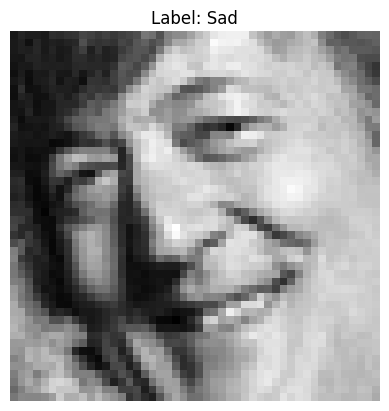

In [31]:
import matplotlib.pyplot as plt
import torch

# Get one image and its label from the batch
image = images[0]  # First image in the batch
label = labels[0].item()  # Get label as an integer

# Convert tensor image to NumPy for visualization
image_np = image.squeeze(0).numpy()  # Remove channel dimension (if grayscale)

# Display the image
plt.imshow(image_np, cmap="gray")  # Use 'gray' colormap for grayscale images
plt.title(f"Label: {'Happy' if label == 0 else 'Sad'}")  # Update label mapping accordingly
plt.axis("off")  # Hide axes
plt.show()



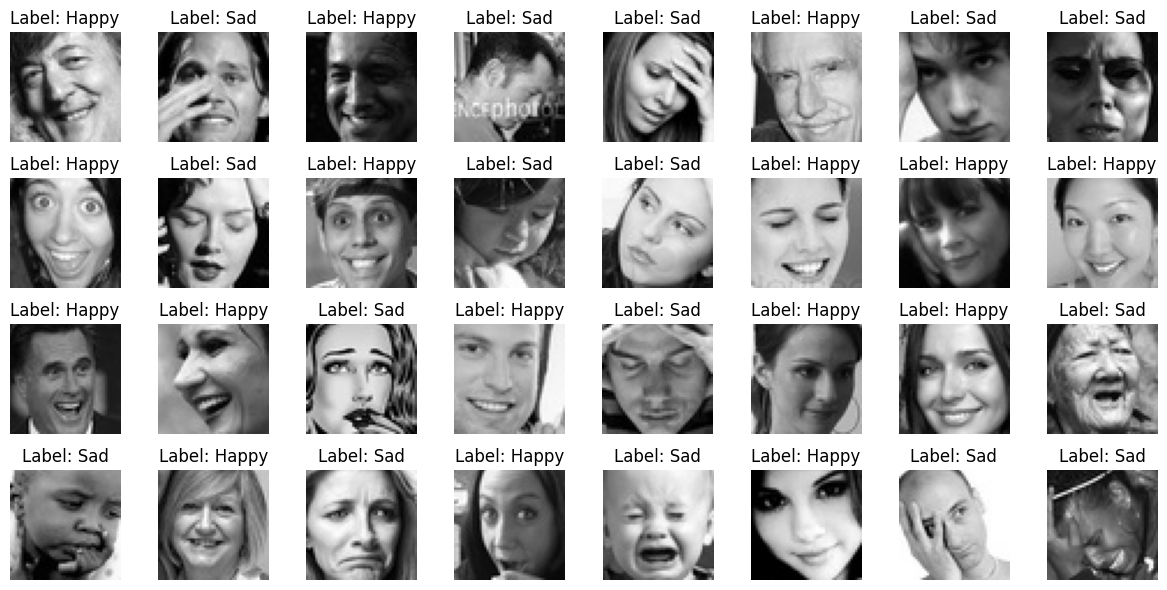

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of data from the train_loader
images, labels = next(iter(train_loader))

# Create a figure with subplots
fig, axes = plt.subplots(4, 8, figsize=(12, 6))  # 4 rows, 8 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the images in the batch
for i in range(32):
    # Convert each image from tensor to numpy array
    image = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    axes[i].imshow(image)
    axes[i].imshow(image, cmap="gray")  
    # Set the title based on the label
    label = labels[i].item()
    axes[i].set_title(f"Label: {'Happy' if label == 0 else 'Sad'}")
    axes[i].axis('off')  # Turn off axis for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



In [7]:
image, label = train_data[0]

In [ ]:
image

In [8]:
image.size()

torch.Size([1, 48, 48])

In [9]:
# Check if DataLoader is working
print(f"Train loader has {len(train_loader)} batches")
print(f"Test loader has {len(test_loader)} batches")

# Check first batch in the train loader
images, labels = next(iter(train_loader))
print(f"First batch of images shape: {images.shape}")
print(f"First batch of labels: {labels}")


Train loader has 223 batches
Test loader has 53 batches
First batch of images shape: torch.Size([32, 1, 48, 48])
First batch of labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0])


In [10]:
def calculate_output_size(input_size, kernel_size, stride=1, padding=0, pool_size=2):
    conv_output = (input_size - kernel_size + 2*padding) // stride + 1
    pool_output = (conv_output - pool_size) // pool_size + 1
    return pool_output

# For a 48x48 input image (FER2013 dimensions)
h = w = 48
h = calculate_output_size(h, kernel_size=5)  # After first conv-pool
h = calculate_output_size(h, kernel_size=5)  # After second conv-pool
print(h)  # This should give you the final spatial dimension


9


In [ ]:
h = (48 - 5) // 2 + 1 = 22
w = (48 - 5) // 2 + 1 = 22

In [ ]:
h = (22 - 5) // 2 + 1 = 9
w = (22 - 5) // 2 + 1 = 9

In [ ]:
flattened_features = 16 * 9 * 9 = 1296

In [25]:
print(len(train_loader))

223


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Print the device being used
print(f"Model is being run on: {device}")

# I believe there is no GPU due I am using virtual machine

Model is being run on: cpu


In [18]:
#First test 
class_names = ['happy', 'sad']

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Input: 3 channels, Output: 6 channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # Input: 6 channels, Output: 16 channels
        
        # Calculate flattened dimension
        self.flattened_features = 16 * 9 * 9  # 16 channels × 9×9 spatial dims
        #1296
        self.fc1 = nn.Linear(self.flattened_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # 2 output classes for FER2013
    #Doing test with Sigmoid
    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))  # Apply conv1 + Sigmoid + pooling
        x = self.pool(torch.sigmoid(self.conv2(x)))  # Apply conv2 + Sigmoid + pooling
        x = torch.flatten(x, 1)  # Flatten dynamically
        x = torch.sigmoid(self.fc1(x))  # Apply fc1 + Sigmoid
        x = torch.sigmoid(self.fc2(x))  # Apply fc2 + Sigmoid
        x = self.fc3(x)  # Output layer 
        return x


# Initialize network, loss, and optimizer
net_test1 = NeuralNet()

# Check if CUDA is available and move the model to the GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_test1.to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
#For binary classification tasks, it's common to use the cross-entropy loss function with a softmax activation function on the output layer.
#softmax is already included

optimizer_test1 = optim.SGD(net_test1.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    print(f'Training epoch {epoch + 1}...')
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to the device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_test1.zero_grad()  # Zero the gradients
        outputs = net_test1(inputs)  # Forward pass
        loss = loss_function(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer_test1.step()  # Update the weights

        running_loss += loss.item()  # Accumulate loss

    # Print the average loss per epoch
    print(f'Loss: {running_loss / len(train_loader):.4f}')

# Save the trained model
#I forgot to replace the name here in the new test, so I will re-do it
torch.save(net_test1.state_dict(), 'trained_net_test1.pth')

# Load the trained model
net_test1.load_state_dict(torch.load('trained_net_test1.pth'))
net_test1.eval()  # Set the model to evaluation mode

Training epoch 1...
Loss: 0.6941
Training epoch 2...
Loss: 0.6936
Training epoch 3...
Loss: 0.6941
Training epoch 4...
Loss: 0.6935
Training epoch 5...
Loss: 0.6934
Training epoch 6...
Loss: 0.6936
Training epoch 7...
Loss: 0.6937
Training epoch 8...
Loss: 0.6934
Training epoch 9...
Loss: 0.6935
Training epoch 10...
Loss: 0.6933
Training epoch 11...
Loss: 0.6936
Training epoch 12...
Loss: 0.6945
Training epoch 13...
Loss: 0.6935
Training epoch 14...
Loss: 0.6935
Training epoch 15...
Loss: 0.6938
Training epoch 16...
Loss: 0.6938
Training epoch 17...
Loss: 0.6940
Training epoch 18...
Loss: 0.6934
Training epoch 19...
Loss: 0.6942
Training epoch 20...
Loss: 0.6933
Training epoch 21...
Loss: 0.6941
Training epoch 22...
Loss: 0.6936
Training epoch 23...
Loss: 0.6939
Training epoch 24...
Loss: 0.6943
Training epoch 25...
Loss: 0.6939
Training epoch 26...
Loss: 0.6939
Training epoch 27...
Loss: 0.6938
Training epoch 28...
Loss: 0.6941
Training epoch 29...
Loss: 0.6938
Training epoch 30...
Lo

NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

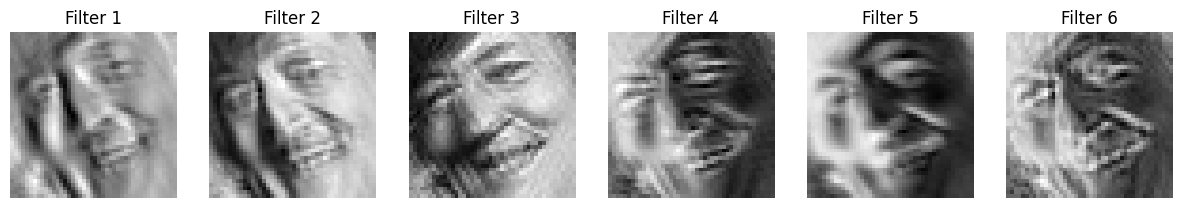

In [33]:
# Jus for the sake of understanding I want to see how one image comes out after the first Conv
net_test1.eval()  # getting it from previous model
with torch.no_grad(): #Disable gradient computation
    image = images[0].unsqueeze(0)  # Add batch dimension, we need to reshape it from [C, H, W] to [1, C, H, W], where 1 is the batch size.
    #cause I am getting just one image (1, 1, 48, 48)
    feature_maps = net_test1.conv1(image)  # Get output of first conv layer

# Convert feature maps to NumPy for visualization
feature_maps = feature_maps.squeeze(0).numpy() # removing 1 from the imagea. From (1, 6, 48, 48) to (6, 48, 48)
#and converting from pytorch to numpy as it is required to matplot

# Plot first 6 feature maps (since conv1 has 6 filters)
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    axes[i].imshow(feature_maps[i], cmap="gray")
    axes[i].set_title(f"Filter {i+1}")
    axes[i].axis("off")
plt.show()


In [19]:
def evaluate_model(model, test_name):
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'[{test_name}] Accuracy: {accuracy:.2f}%')
    return accuracy  # Return accuracy if needed


In [20]:
evaluate_model(net_test1, "test1")

[test1] Accuracy: 50.39%


50.390390390390394

In [30]:
# Second test

class_names = ['happy', 'sad']

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        #self.conv1 = nn.Conv2d(3, 6, 5)  # Input: 3 channels, Output: 6 channels
        self.conv1 = nn.Conv2d(1, 6, 5)  # Input: 3 channels, Output: 6 channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # Input: 6 channels, Output: 16 channels
        
        # Calculate flattened dimension
        self.flattened_features = 16 * 9 * 9  # 16 channels × 9×9 spatial dims
        
        self.fc1 = nn.Linear(self.flattened_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # 2 output classes for FER2013

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1 + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2 + ReLU + pooling
        x = torch.flatten(x, 1)  # Flatten dynamically
        x = F.relu(self.fc1(x))  # Apply fc1 + ReLU
        x = F.relu(self.fc2(x))  # Apply fc2 + ReLU
        x = self.fc3(x)  # Output layer
        return x




# Initialize network, loss, and optimizer
net_test2 = NeuralNet()

# Check if CUDA is available and move the model to the GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_test2.to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
#For binary classification tasks, it's common to use the cross-entropy loss function with a softmax activation function on the output layer.
#softmax is already included
#U sing Stochastic Gradient Descent as optimization alpgorithm
optimizer_test2 = optim.SGD(net_test2.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    print(f'Training epoch {epoch + 1}...')
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to the device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_test2.zero_grad()  # Zero the gradients
        outputs = net_test2(inputs)  # Forward pass
        loss = loss_function(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer_test2.step()  # Update the weights

        running_loss += loss.item()  # Accumulate loss

    # Print the average loss per epoch
    print(f'Loss: {running_loss / len(train_loader):.4f}')

# Save the trained model
#I forgot to replace the name here in the new test, so I will re-do it
torch.save(net_test2.state_dict(), 'trained_net_test2.pth')

# Load the trained model
net_test2.load_state_dict(torch.load('trained_net_test2.pth'))
net_test2.eval()  # Set the model to evaluation mode


Training epoch 1...
Loss: 0.6920
Training epoch 2...
Loss: 0.6879
Training epoch 3...
Loss: 0.6801
Training epoch 4...
Loss: 0.6679
Training epoch 5...
Loss: 0.6527
Training epoch 6...
Loss: 0.6346
Training epoch 7...
Loss: 0.6192
Training epoch 8...
Loss: 0.6058
Training epoch 9...
Loss: 0.5892
Training epoch 10...
Loss: 0.5737
Training epoch 11...
Loss: 0.5581
Training epoch 12...
Loss: 0.5431
Training epoch 13...
Loss: 0.5300
Training epoch 14...
Loss: 0.5168
Training epoch 15...
Loss: 0.5069
Training epoch 16...
Loss: 0.4943
Training epoch 17...
Loss: 0.4804
Training epoch 18...
Loss: 0.4664
Training epoch 19...
Loss: 0.4536
Training epoch 20...
Loss: 0.4404
Training epoch 21...
Loss: 0.4239
Training epoch 22...
Loss: 0.4076
Training epoch 23...
Loss: 0.3960
Training epoch 24...
Loss: 0.3783
Training epoch 25...
Loss: 0.3705
Training epoch 26...
Loss: 0.3469
Training epoch 27...
Loss: 0.3352
Training epoch 28...
Loss: 0.3185
Training epoch 29...
Loss: 0.3070
Training epoch 30...
Lo

NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [13]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)  # Pass inputs to the network
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy: {accuracy}%')



Accuracy: 79.03903903903904%


In [14]:
# Save the accuracy to a file and print it
with open('model_results.txt', 'w') as f:
    print(f'Accuracy: {accuracy}%')
    f.write(f'Accuracy: {accuracy}%\n')
    print(f'Model Architecture: {net}')
    f.write(f'Model Architecture: {net}\n')
    print(f'Loss Function: {loss_function}')
    f.write(f'Loss Function: {loss_function}\n')
    print(f'Optimizer: {optimizer}')
    f.write(f'Optimizer: {optimizer}\n')    

Accuracy: 79.03903903903904%
Model Architecture: NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
Loss Function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate additional metrics
predicted = torch.max(outputs, 1)[1].cpu().numpy()
precision = precision_score(labels, predicted)
recall = recall_score(labels, predicted)
f1 = f1_score(labels, predicted)

# Save and print these metrics as well
with open('model_results.txt', 'a') as f:
    print(f'Precision: {precision:.2f}')
    f.write(f'Precision: {precision:.2f}\n')
    print(f'Recall: {recall:.2f}')
    f.write(f'Recall: {recall:.2f}\n')
    print(f'F1 Score: {f1:.2f}')
    f.write(f'F1 Score: {f1:.2f}\n')


Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [7]:
spark.stop()

In [7]:
# I did this to increase spark heartbeat was it was stopping in the next test
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .config("spark.executor.heartbeatInterval", "600s") \
    .config("spark.network.timeout", "1000s") \
    .getOrCreate()


25/03/23 20:10:47 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [26]:
#Third test 

class_names = ['happy', 'sad']

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        #self.conv1 = nn.Conv2d(3, 6, 5)  # Input: 3 channels, Output: 6 channels
        self.conv1 = nn.Conv2d(1, 16, 5)  # Input: 3 channels, Output: 6 channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)  # Input: 6 channels, Output: 16 channels
        
        # Calculate flattened dimension
        #self.flattened_features = 16 * 9 * 9  # 16 channels × 9×9 spatial dims
        self.flattened_features = 2592 #32 * 9 * 9
        self.fc1 = nn.Linear(self.flattened_features, 120)

        #self.fc1 = nn.Linear(self.flattened_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # 2 output classes for FER2013

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1 + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2 + ReLU + pooling
        x = torch.flatten(x, 1)  # Flatten dynamically
        x = F.relu(self.fc1(x))  # Apply fc1 + ReLU
        x = F.relu(self.fc2(x))  # Apply fc2 + ReLU
        x = self.fc3(x)  # Output layer
        return x


# Initialize network, loss, and optimizer
net_test3 = NeuralNet()

# Check if CUDA is available and move the model to the GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_test3.to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
#For binary classification tasks, it's common to use the cross-entropy loss function with a softmax activation function on the output layer.
#softmax is already included

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer_test3 = optim.Adam(net_test3.parameters(), lr=0.001)  # Using Adam optimizer for potentially better performance
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    print(f'Training epoch {epoch + 1}...')
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to the device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_test3.zero_grad()  # Zero the gradients
        outputs = net_test3(inputs)  # Forward pass
        loss = loss_function(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer_test3.step()  # Update the weights

        running_loss += loss.item()  # Accumulate loss

    # Print the average loss per epoch
    print(f'Loss: {running_loss / len(train_loader):.4f}')

# Save the trained model
torch.save(net_test3.state_dict(), 'trained_test3.pth')

# Load the trained model
net_test3.load_state_dict(torch.load('trained_test3.pth'))
net_test3.eval()  # Set the model to evaluation mode


Training epoch 1...
Loss: 0.5826
Training epoch 2...
Loss: 0.4441
Training epoch 3...
Loss: 0.3780
Training epoch 4...
Loss: 0.3321
Training epoch 5...
Loss: 0.2729
Training epoch 6...
Loss: 0.2271
Training epoch 7...
Loss: 0.1717
Training epoch 8...
Loss: 0.1342
Training epoch 9...
Loss: 0.0849
Training epoch 10...
Loss: 0.0577
Training epoch 11...
Loss: 0.0498
Training epoch 12...
Loss: 0.0300
Training epoch 13...
Loss: 0.0160
Training epoch 14...
Loss: 0.0334
Training epoch 15...
Loss: 0.0359
Training epoch 16...
Loss: 0.0299
Training epoch 17...
Loss: 0.0223
Training epoch 18...
Loss: 0.0218
Training epoch 19...
Loss: 0.0280
Training epoch 20...
Loss: 0.0296
Training epoch 21...
Loss: 0.0142
Training epoch 22...
Loss: 0.0200
Training epoch 23...
Loss: 0.0188
Training epoch 24...
Loss: 0.0122
Training epoch 25...
Loss: 0.0048
Training epoch 26...
Loss: 0.0008
Training epoch 27...
Loss: 0.0002
Training epoch 28...
Loss: 0.0001
Training epoch 29...
Loss: 0.0001
Training epoch 30...
Lo

NeuralNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2592, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [29]:
evaluate_model(net_test3, "test3")

[test3] Accuracy: 82.34%


82.34234234234235

In [11]:
print(f'Loss: {running_loss / len(train_loader):.6f}')


Loss: 0.000017


In [12]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)  # Pass inputs to the network
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy: {accuracy}%')

Accuracy: 81.92192192192192%


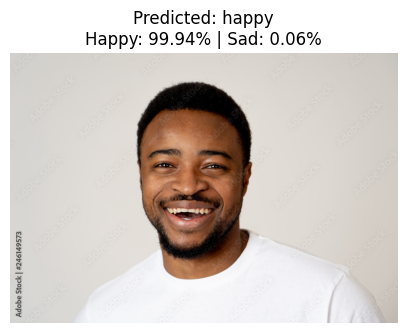

In [49]:
# Function to make prediction
def predict_and_display(image_path, model, transform, class_names, device):
    # I just want to display the image
    original_image = Image.open(image_path)
    image = transform(original_image)  # Apply the same transformations
    image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)  #apply the last model 
        probabilities = torch.nn.functional.softmax(output, dim=1)[0] * 100  # Apply softmax to get probabilities
        predicted_class = torch.argmax(probabilities).item()
        happy_prob = probabilities[0].item()
        sad_prob = probabilities[1].item()

    # Display the original image and prediction results
    plt.figure(figsize=(5, 5))
    plt.imshow(original_image)
    plt.title(f"Predicted: {class_names[predicted_class]}\nHappy: {happy_prob:.2f}% | Sad: {sad_prob:.2f}%")
    plt.axis("off")
    plt.show()

# Example usage
image_path = "images_prediciton1.jpg"  # Change this to your local image path

# Call the function
predict_and_display(image_path, net_test3, transform, class_names, device)


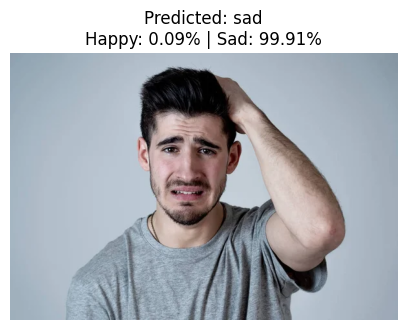

In [52]:
# Example usage
image_path = "image_predicition2.webp"  # Change this to your local image path

# Call the function
predict_and_display(image_path, net_test3, transform, class_names, device)